## Imports

In [71]:
import pathlib
import PIL.Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import glob
import os
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

## Read Image Data

In [72]:
#Set data directory
data_dir = pathlib.Path('data-no-trash')

In [73]:
#show number of images included in directory
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2526


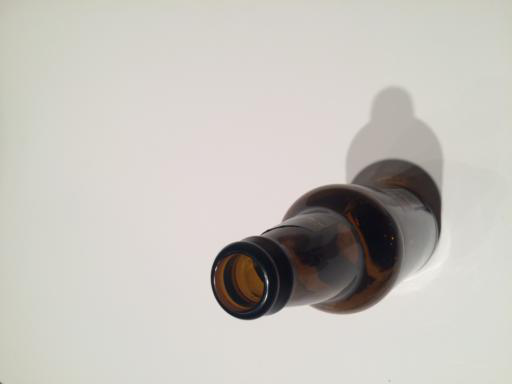

In [74]:
#Display a sample glass image
glass = list(data_dir.glob('glass/*'))
PIL.Image.open(str(glass[0]))

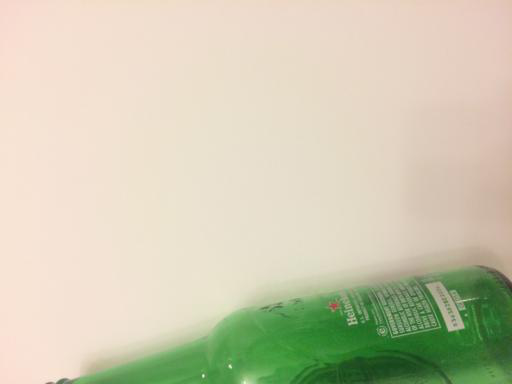

In [75]:
#Display another sample glass image
PIL.Image.open(str(glass[1]))

In [76]:
base_path = data_dir

img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))

2526


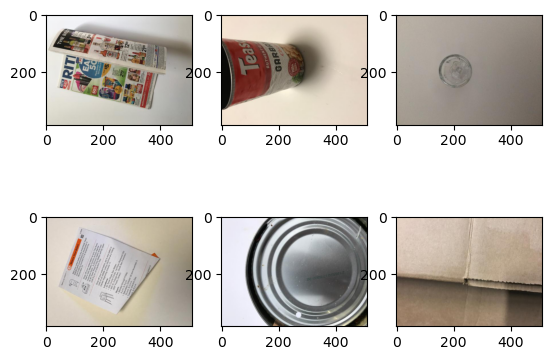

In [77]:
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

## Load Dataset

In [78]:
#Define some parameters for the loader:
batch_size = 32
img_height = 384
img_width = 512

#TODO: Resize to smaller size

In [79]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 2288 images belonging to 6 classes.
Found 252 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'other', 4: 'paper', 5: 'plastic'}


In [80]:
# def train_test_split_folders(data_dir):
#     splitfolders.ratio(data_dir, output="images", seed=1337, ratio=(.8, 0.1,0.1))
#     image_dir = 'images'

#     #create training split  
#     train_ds = tf.keras.utils.image_dataset_from_directory(
#     image_dir + '/train',
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size)

#     #create validation split
#     val_ds = tf.keras.utils.image_dataset_from_directory(
#     image_dir + '/val',
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size)

#     #create validation split
#     test_ds = tf.keras.utils.image_dataset_from_directory(
#     image_dir + '/test',
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size)

#     return train_ds, val_ds, test_ds

# train_ds, val_ds, test_ds = train_test_split_folders(data_dir=data_dir)

In [81]:
# #Show names of the found classes
# class_names = train_ds.class_names
# print(class_names)

## Configure the dataset

*Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:*

    - Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
    
    - Dataset.prefetch overlaps data preprocessing and model execution while training.

*Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.*

## Standardize the data

In [82]:
# intializing rescaling layer to map onto data in the next step
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [83]:
# # creating the normalized dataset
 
# normalized_ds = train_generator.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in '[0, 1]'
# print(np.min(first_image), np.max(first_image))

In [84]:
# AUTOTUNE = tf.data.AUTOTUNE

# #load data into cache to reduce i/o
# train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = validation_generator.cache().prefetch(buffer_size=AUTOTUNE)

In [85]:
num_classes = len(labels)

model = tf.keras.Sequential(
    [
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
    ]
)

In [86]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [87]:
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator, 
    epochs=10
)

C:\Users\Felix\AppData\Local\Temp\ipykernel_10720\409207409.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
143/143 [==============================] - 35s 242ms/step - loss: 8.7853 - accuracy: 0.2181 - val_loss: 8.8905 - val_accuracy: 0.1984
Epoch 2/10
143/143 [==============================] - 34s 240ms/step - loss: 8.9044 - accuracy: 0.1976 - val_loss: 8.8905 - val_accuracy: 0.1984
Epoch 3/10
143/143 [==============================] - 34s 240ms/step - loss: 8.9044 - accuracy: 0.1976 - val_loss: 8.8905 - val_accuracy: 0.1984
Epoch 4/10
143/143 [==============================] - 35s 243ms/step - loss: 8.9044 - accuracy: 0.1976 - val_loss: 8.8905 - val_accuracy: 0.1984
Epoch 5/10
143/143 [==============================] - 34s 240ms/step - loss: 8.9044 - accuracy: 0.1976 - val_loss: 8.8905 - val_accuracy: 0.1984
Epoch 6/10
143/143 [==============================] - 34s 239ms/step - loss: 8.9044 - accuracy: 0.1976 - val_loss: 8.8905 - val_accuracy: 0.1984
Epoch 7/10
 53/143 [==========>...................] - ETA: 21s - loss: 8.9904 - accuracy: 0.2028

KeyboardInterrupt: 

In [ ]:
#export training history
save = True

if save:
    np.save('test2_history.npy',history.history)

In [ ]:
history = history.history

In [ ]:
#import training history
load = False

if load:
    history=np.load('my_history.npy',allow_pickle='TRUE').item()

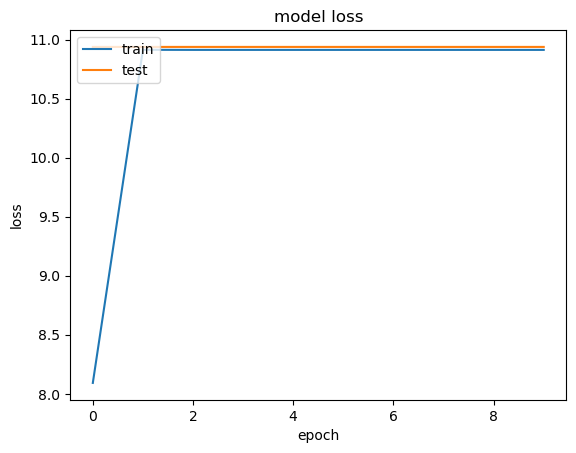

In [ ]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

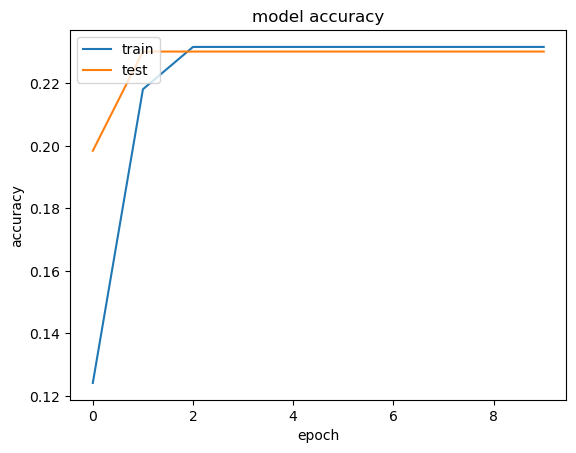

In [ ]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

NameError: name 'predictions' is not defined

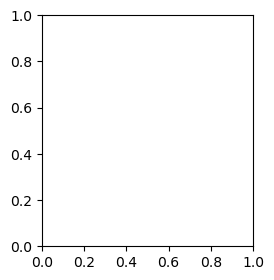

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

In [ ]:
# TODO: Tensorboard
# TODO: Predict Sample image
# TODO: Model Optimizer implementieren (KERAS Tuner)